# 1. 사전 세팅

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/8_creditcard_fraud_detection"

# 2. 문제 정의

---

    대부분의 국가에서 신용카드 사용이 일반화되고 있다.
    신용카드 사용자들은 항상 분실에 대한 우려를 가지고 있고, 신용카드 회사들은 분실했을 경우,
    사용하는 패턴이 달라지는 것을 감지해 신용카드를 정지하는 시스템(Fraud Detection System)을 보유하고 있다.
    데이터를 통해 이런 패턴을 자동으로 감지할 수 있다면, 카드 오용으로 인한 피해를 미연에 방지할 수 있다.


## 2.1 도메인 지식

---

▸ Fraud Detection System(FDS)

    현재는 범용적인 특정 조건들에 의해서 탐지를 진행하고 있다.
    예전에는 Association Rule처럼 연관되어 있는 규칙만을 따랐다면, 요즘에는 패턴 및 가족 구성원 같은 데이터도 고려하고 있다.

▸ 가게 규모에 따른 수수료율

    흔히 영세 상인과 같은 규모가 작은 곳은 수수료가 없는 편이고, 대형 마트같은 곳은 상대적으로 수수료율을 매기는 등, 수수료율을 차등으로 매긴다.

# 3. 데이터 간단 확인

## 3.1 데이터 살펴보기

In [ ]:
import pandas as pd

df = pd.read_csv('Data/data.csv')

print(['{}:{}'.format(i, name) for (i, name) in enumerate(list(df.columns))])



```
['0:class', '1:v1', '2:v2', '3:v3', '4:v4', '5:v5', '6:v6', '7:v7', '8:v8', '9:v9', '10:v10', '11:v11', '12:v12',
 '13:v13', '14:v14', '15:v15', '16:v16', '17:v17', '18:v18', '19:v19', '20:v20', '21:v21', '22:v22', '23:v23',
 '24:v24', '25:v25', '26:v26', '27:v27', '28:v28', '29:log_amount']
```



    민감 정보이기 때문에 비식별화되어있는 컬럼 형태로 주어져있다.

In [ ]:
# 본 데이터는 feature에 대한 Description이 없기에, Feature Selection을 하기 어려움
df.columns.tolist()

In [ ]:
df.isnull().sum()

In [ ]:
print(df['class'].value_counts())



```
class
0    284315
1       492
Name: count, dtype: int64
```



## 3.2 데이터 명세

---

| Column | Description |
| :------------------ | :------------------------- |
| Features | 신용카드 거래 관련 정보 |
| Class        | 이상거래 여부 |

In [ ]:
df.head()

In [ ]:
df.shape



```
(284807, 30)
```



## 3.3 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox"> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>데이터 분할</b><br><br>- Data Imbalance 특성을 고려하기 위해 5% 수준으로 under-sampling 진행<br>- over-sampling을 통해 Data Inbalance 조정 |
| 가공 결과 | <b>As is</b><br><br>- row: 284315 / column: 30 / table: 1<br><br> <b>To be</b><br><br>- row: 14216(-270099) / column: 30 / table: 1  |

# 4. 문제 해결 프로세스 정의

---

▸ 문제

    대부분의 사람들은 요즘 신용카드를 사용한다.
    신용카드는 사용에 있어서 높은 편의성을 제공하지만, 카드의 분실 혹은 도난으로 인한 이상거래가 발생할 수 있다.

    1. As-Is
    대부분의 금융 기관에서는 특정 조건(시간, 장소 등)과 개인의 특성을 매핑해 트리거를 만들어서 경보 시스템을 운영한다.
    예를 들어, 60대의 신용카드가 새벽 2시에 사용되었다면, 알림이 가는 시스템이다.

    2. To-Be
    위와 같은 조건으로 알림을 주는 것도 이상거래를 탐지할 수 있지만,
    다양한 Feature를 활용해 복합적인 상황에서의 이상거래를 탐지하기 위한 모델링을 하고자 한다.

    3. Goal
    수많은 신용카드 이용 내역 중, 이상거래를 탐지할 수 있는 모델을 만들고,
    이상거래의 경우 데이터가 매우 Imbalance하기에 오버샘플링을 진행할 예정.
    
▸ 기대 효과

    이상거래 탐지 모델링을 통한 자동 탐지 기능 적용
    이상거래를 통해 발생하는 고객의 피해 금액 감소

▸ 해결 방안

    Binary Classification을 통한 이상거래 여부 분류
    Logistic, KNN, RandomForest 이용

▸ 성과 측정

    이상 거래 탐지율

# 5. Data Readiness Check

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from time import time
from pprint import pprint

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, cohen_kappa_score, precision_recall_fscore_support

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
pd.concat([df['class'].value_counts(),
           df['class'].value_counts(normalize=True).round(5)], axis=1)

| class | count | proportion |
| :---: | ---: | ---: |
| 0 | 284315 | 0.99827 |
| 1 | 492 | 0.00173 |

In [ ]:
# 비정상을 5% 가져온다면, 정상도 5% 가져가야 함.
y0_undersampled = df.loc[df['class'] == 0, :].sample(frac=0.05, replace=False, random_state=1)
y1_undersampled = df.loc[df['class'] == 1, :].sample(frac=0.05, replace=False, random_state=1)

In [ ]:
df_undersampled = pd.concat([y0_undersampled, y1_undersampled], axis=0)

In [ ]:
pd.concat([df_undersampled['class'].value_counts(),
           df_undersampled['class'].value_counts(normalize=True).round(5)], axis=1)

| class | count | proportion |
| :---: | ---: | ---: |
| 0 | 14216 | 0.99824 |
| 1 | 25 | 0.00176 |

In [ ]:
neg, pos = np.bincount(df_undersampled['class'])
total = neg + pos

print('Total: {}\nPositive: {} ({:.3f}% of total)'.format(
    total, pos, 100 * pos / total
))



```
Total: 14241
Positive: 25 (0.176% of total)
```



In [ ]:
X = df_undersampled.iloc[:, 1:].values
y = df_undersampled['class'].values.astype(int)

y_labels = ['Not Fraud', 'Fraud']

print('Class labels:', np.unique(y), y_labels, [(i, int(val)) for (i, val) in enumerate(np.bincount(y))])



```
Class labels: [0 1] ['Not Fraud', 'Fraud'] [(0, 14216), (1, 25)]
```



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
print('Labels counts in y:', np.bincount(y), [round(cnt/np.sum(np.bincount(y)) * 100, 1) for cnt in np.bincount(y)])
print('Labels counts in y_train:', np.bincount(y_train), [round(cnt/np.sum(np.bincount(y_train)) * 100, 1) for cnt in np.bincount(y_train)])
print('Labels counts in y_test:', np.bincount(y_test), [round(cnt/np.sum(np.bincount(y_test)) * 100, 1) for cnt in np.bincount(y_test)])



```
Labels counts in y: [14216    25] [np.float64(99.8), np.float64(0.2)]
Labels counts in y_train: [9951   17] [np.float64(99.8), np.float64(0.2)]
Labels counts in y_test: [4265    8] [np.float64(99.8), np.float64(0.2)]
```



In [ ]:
data = pd.DataFrame(np.hstack((y_train.reshape(-1, 1), X_train)), columns=list(df.columns))

data.describe().T.round(2)

In [ ]:
f, axs = plt.subplots(15, 2, figsize=(20, 70))

for i, feat in enumerate(X_train.T):
    sns.distplot(feat[y_train==0], ax=axs.flat[i], label='{}: {}'.format('Not Fraud', len(y_train[y_train==0])))
    sns.distplot(feat[y_train==1], ax=axs.flat[i], label='{}: {}'.format('Fraud', len(y_train[y_train==1])))
    axs.flat[i].set_title('{}: mean: {} std: {}'.format(list(data.columns)[i+1], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()

plt.tight_layout()
plt.show()



```
결정 경계가 분명한 변수들은 유용하게 잘 사용할 수 있을 것이다 !!
(물론 현재 데이터의 변수로는 알 수가 없음)
```



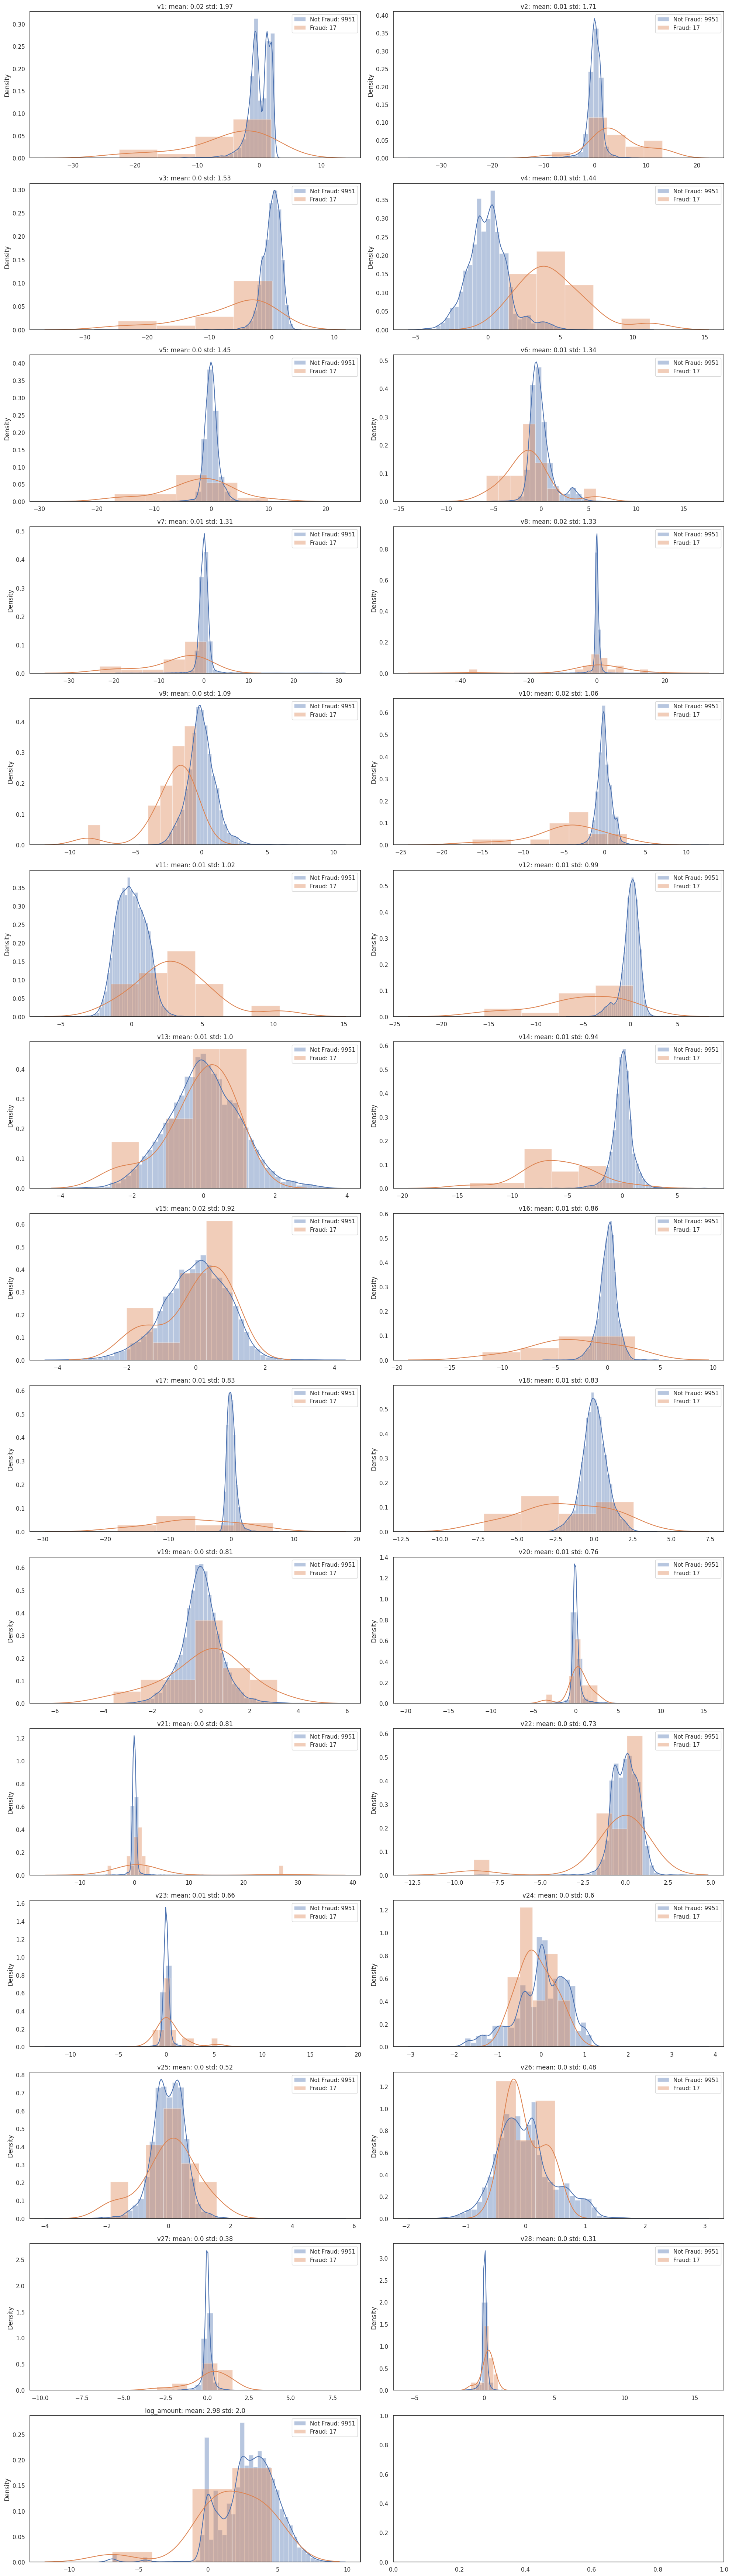

In [ ]:
plt.figure(figsize=(30, 30))

matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, fmt='.2g',
            mask=matrix, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=100))

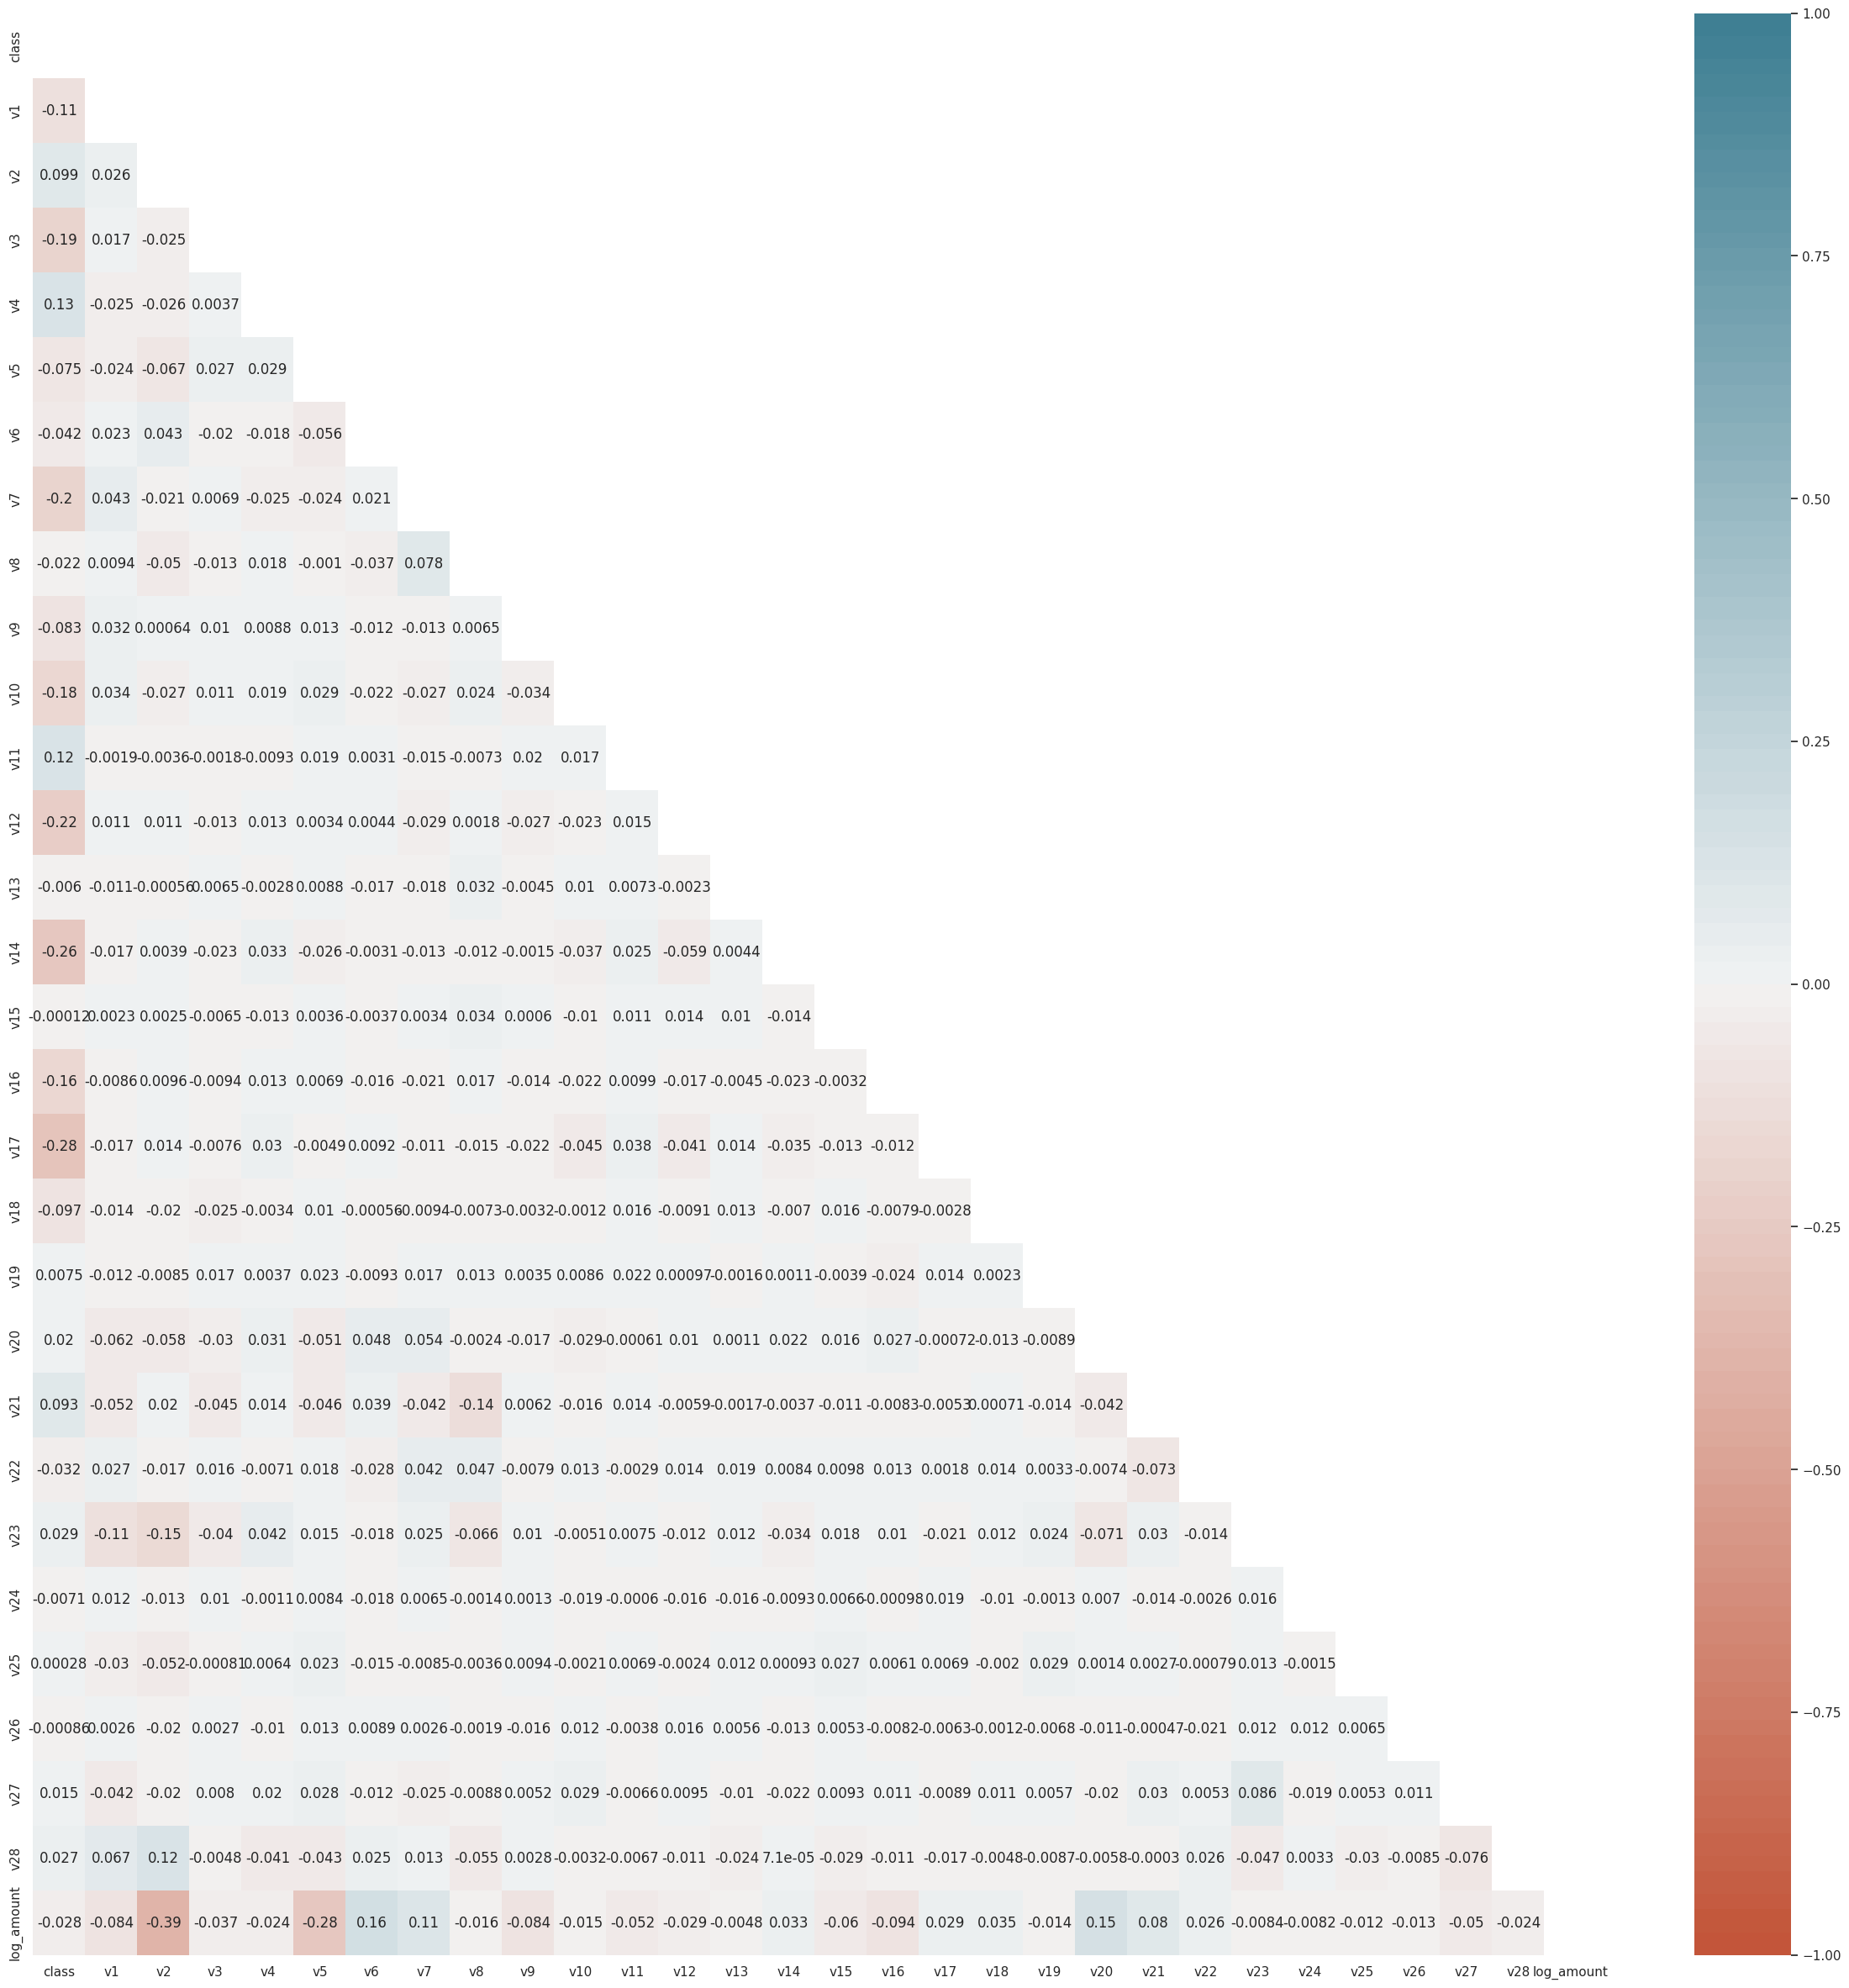

In [ ]:
sns.pairplot(data.iloc[:, :7], vars=list(data.columns)[:7],
             kind='reg', diag_kind='hist', hue='class',
             corner=True, plot_kws={'scatter_kws': {'alpha': 0.05},
                                    'x_jitter': 0.1, 'y_jitter': 0.1})

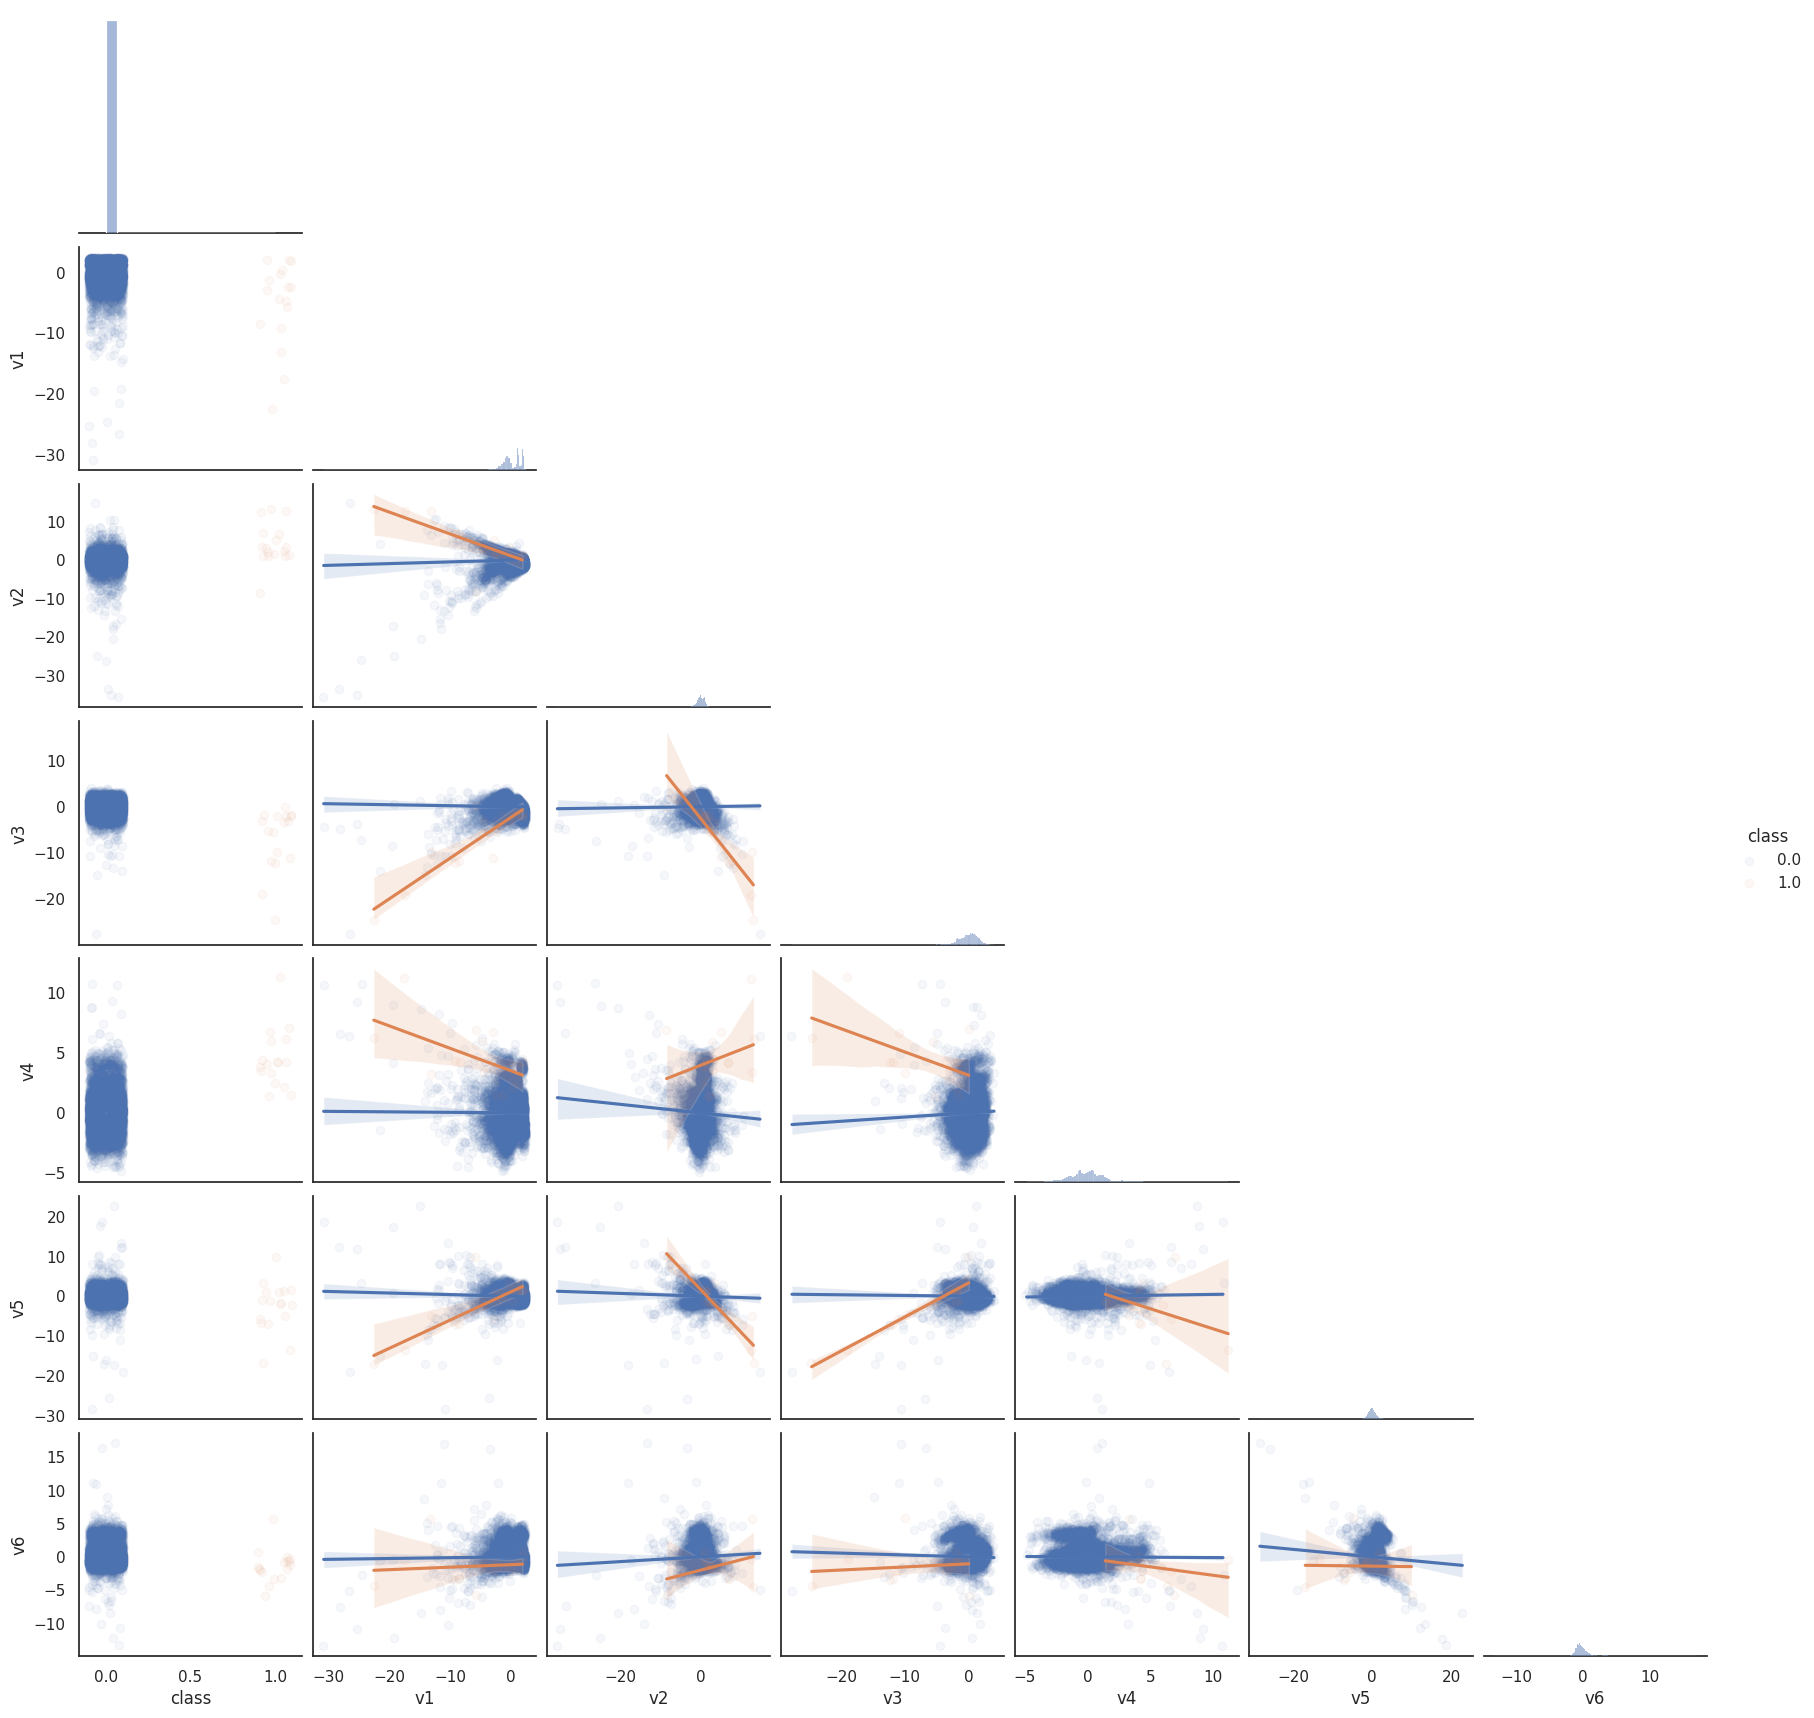

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

f, axs = plt.subplots(15, 2, figsize=(20, 70))

for i, feat in enumerate(X_train_std.T):
    sns.distplot(feat[y_train==0], ax=axs.flat[i], label='{}: {}'.format('Not Fraud', len(y_train[y_train==0])))
    sns.distplot(feat[y_train==1], ax=axs.flat[i], label='{}: {}'.format('Fraud', len(y_train[y_train==1])))
    axs.flat[i].set_title('{}: mean: {} std: {}'.format(list(data.columns)[i+1], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()

plt.tight_layout()
plt.show()

# 6. 모델링

## 6.1 Logistic Regression

In [ ]:
lr_clf = LogisticRegressionCV(cv=3, penalty='elasticnet', solver='saga',
                              Cs=np.power(10, np.arange(-3, 1, dtype=float)),
                              l1_ratios=np.linspace(0, 1, num=6, dtype=float),
                              max_iter=1000, random_state=0, n_jobs=3)

start = time()
lr_clf.fit(X_train_std, y_train)
lr_duration = time() - start

In [ ]:
print('LogisticRegressionCV took {:.2f} seconds for {} cv iterations with {} parameter settings.'.format(lr_duration,
                                                                                                         lr_clf.n_iter_.shape[1],
                                                                                                         lr_clf.n_iter_.shape[2] * lr_clf.n_iter_.shape[3]))
print('Optimal regularzation strength: {} Optimal L1 Ratio: {}'.format(lr_clf.C_[0], lr_clf.l1_ratio_[0]))
print('Accuracy (train): {:.2f}'.format(lr_clf.score(X_train_std, y_train)))
print('Accuracy (test): {:.2f}'.format(lr_clf.score(X_test_std, y_test)))



```
LogisticRegressionCV took 385.99 seconds for 3 cv iterations with 24 parameter settings.
Optimal regularzation strength: 1.0 Optimal L1 Ratio: 0.0
Accuracy (train): 1.00
Accuracy (test): 1.00
```



In [ ]:
lr_params = dict(zip(list(data.columns)[1:], list(lr_clf.coef_[0])),
                 intercept=lr_clf.intercept_[0])
{param: float(value.round(2)) for (param, value) in sorted(lr_params.items(), key=lambda item: item[1], reverse=True)}



```
{'v1': 0.89, 'v4': 0.75, 'v5': 0.51, 'v28': 0.39,
 'v27': 0.31, 'v24': 0.22, 'v22': 0.21, 'v23': 0.11,
 'v13': 0.1, 'v20': 0.08, 'v11': 0.05, 'v21': 0.03,
 'v16': 0.0, 'v26': -0.01, 'v18': -0.04, 'v2': -0.1,
 'v3': -0.1, 'v10': -0.18, 'v25': -0.19, 'v7': -0.31,
 'v6': -0.31, 'v12': -0.36, 'log_amount': -0.38, 'v8': -0.39,
 'v15': -0.42, 'v19': -0.45, 'v9': -0.5, 'v17': -0.56,
 'v14': -1.06, 'intercept': -9.76}
```



In [ ]:
predicted_class_labels = lr_clf.predict(X_test_std)
predicted_class_labels



```
array([0, 0, 0, ..., 0, 0, 0])
```



In [ ]:
def get_cross_val(clf, X, y, model_name, cv_num=5, metric='f1'):
    scores = cross_val_score(clf, X, y, cv=cv_num, scoring=metric)
    mean = scores.mean()
    std = scores.std()
    p025 = np.quantile(scores, 0.025)
    p975 = np.quantile(scores, 0.975)
    metrics = ['mean', 'standard deviation', 'p025', 'p975']
    s = pd.Series([mean, std, p025, p975], index=metrics)
    s.name = model_name
    return s

def calculate_metrics(y_true, y_pred, duration, model_name, *args):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ck = cohen_kappa_score(y_true, y_pred)
    p, r, fbeta, support = precision_recall_fscore_support(y_true, y_pred)
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1_score', 'cohen_kappa',
               'precision_both', 'recall_both', 'fbeta_both', 'support_both', 'time_to_fit (seconds)']
    s = pd.Series([acc, pre, rec, roc_auc, f1, ck, p, r, fbeta, support, duration], index=metrics)
    s.name = model_name
    return s

In [ ]:
lr_cv = get_cross_val(lr_clf, X_test_std, y_test, 'Logistic Regression')
lr_cv.round(2)

In [ ]:
y_pred = lr_clf.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_clf.classes_)
disp.plot()
plt.show()

    현재 문제에서는 오탐보다는 미탐을 더 잡아내는 것이 중요함 !! (FP보다 FN을 줄이는 것이 중요한 상황)
    왜냐하면, 이상 거래인데, 이상 거래라고 하지 않는다면, 큰 손실이 발생할 수도 있기 때문에 !

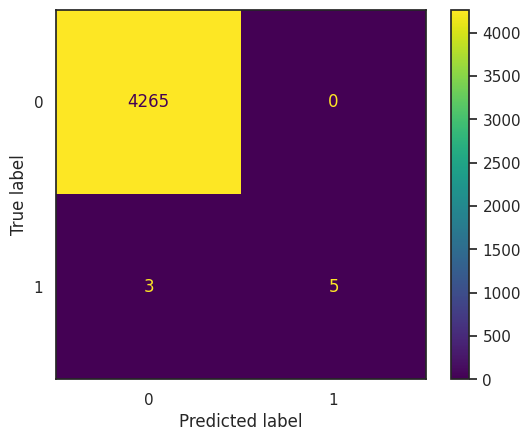

In [ ]:
print(classification_report(y_test, y_pred, target_names=y_labels))



```
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      4265
       Fraud       1.00      0.62      0.77         8

    accuracy                           1.00      4273
   macro avg       1.00      0.81      0.88      4273
weighted avg       1.00      1.00      1.00      4273
```



In [ ]:
lr_metrics = calculate_metrics(y_test, y_pred, lr_duration, 'Logistic Regression')
print(lr_metrics)

    정답이 매우 적은 경우에는 Recall이 엄청 중요하다.



```
accuracy                                                 0.999298
precision                                                     1.0
recall                                                      0.625
roc_auc                                                    0.8125
f1_score                                                 0.769231
cohen_kappa                                              0.768898
precision_both                          [0.9992970946579194, 1.0]
recall_both                                          [1.0, 0.625]
fbeta_both               [0.9996484237665534, 0.7692307692307693]
support_both                                            [4265, 8]
time_to_fit (seconds)                                  385.989167
```



## 6.2 K-Nearest Neighbors

In [ ]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': np.arange(1, 16)}

knn_clf = KNeighborsClassifier()

gs_knn = GridSearchCV(knn_clf, param_grid=param_grid)

start = time()
gs_knn.fit(X_train_std, y_train)
knn_duration = time() - start

print('GridSearchCV of KNN took {:.2f} seconds for {} candidate parameter settings.'.format(knn_duration,
                                                                                            len(gs_knn.cv_results_['params'])))
print('Optimal weights: {} Optimal n_neighbors: {}'.format(gs_knn.best_params_['weights'], gs_knn.best_params_['n_neighbors']))
print('Accuracy (train): {:.2f}'.format(gs_knn.score(X_train_std, y_train)))
print('Accuracy (test): {:.2f}'.format(gs_knn.score(X_test_std, y_test)))



```
GridSearchCV of KNN took 43.65 seconds for 30 candidate parameter settings.
Optimal weights: distance Optimal n_neighbors: 7
Accuracy (train): 1.00
Accuracy (test): 1.00
```



In [ ]:
pprint(gs_knn.best_estimator_.get_params())



```
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': np.int64(7),
 'p': 2,
 'weights': 'distance'}
```



In [ ]:
knn_cv = get_cross_val(gs_knn, X_test_std, y_test, 'KNN')

In [ ]:
print(knn_cv.round(2))



```
mean                  0.73
standard deviation    0.39
p025                  0.07
p975                  1.00
```



In [ ]:
y_pred = gs_knn.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_knn.classes_)
disp.plot()
plt.show()

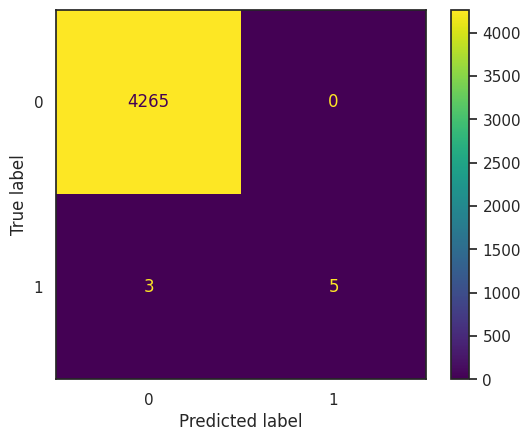

In [ ]:
print(classification_report(y_test, y_pred, target_names=y_labels))



```
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      4265
       Fraud       1.00      0.62      0.77         8

    accuracy                           1.00      4273
   macro avg       1.00      0.81      0.88      4273
weighted avg       1.00      1.00      1.00      4273
```



In [ ]:
knn_metrics = calculate_metrics(y_test, y_pred, knn_duration, 'KNN')
print(knn_metrics)



```
accuracy                                                 0.999298
precision                                                     1.0
recall                                                      0.625
roc_auc                                                    0.8125
f1_score                                                 0.769231
cohen_kappa                                              0.768898
precision_both                          [0.9992970946579194, 1.0]
recall_both                                          [1.0, 0.625]
fbeta_both               [0.9996484237665534, 0.7692307692307693]
support_both                                            [4265, 8]
time_to_fit (seconds)                                   43.645432
```



## 6.3 Linear Discriminant Analysis

In [ ]:
param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'],
              'n_components': np.arange(1, 5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda.fit(X_train_std, y_train)
lda_duration = time() - start

print('GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.'.format(lda_duration,
                                                                                            len(gs_lda.cv_results_['params'])))
print('Optimal solver: {} Optimal shrinkage: {} Optimal n_components: {}'.format(gs_lda.best_params_['solver'], gs_lda.best_params_['shrinkage'], gs_lda.best_params_['n_components']))
print('Accuracy (train): {:.2f}'.format(gs_lda.score(X_train_std, y_train)))
print('Accuracy (test): {:.2f}'.format(gs_lda.score(X_test_std, y_test)))



```
GridSearchCV of LDA took 1.87 seconds for 16 candidate parameter settings.
Optimal solver: lsqr Optimal shrinkage: None Optimal n_components: 1
Accuracy (train): 1.00
Accuracy (test): 1.00
```



In [ ]:
lda_cv = get_cross_val(lda_clf, X_test_std, y_test, 'Linear Discriminant Analysis')
print(lda_cv.round(2))



```
mean                  0.76
standard deviation    0.13
p025                  0.67
p975                  0.98
```



In [ ]:
y_pred = gs_lda.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_lda.classes_)
disp.plot()
plt.show()



```
LDA가 TP를 하나 더 증가시켰다 !
duration은 대폭 줄었는데, 분류 성능이 좋아졌다는 것은 압도적인 성능 차이를 보인다는 것 !
```



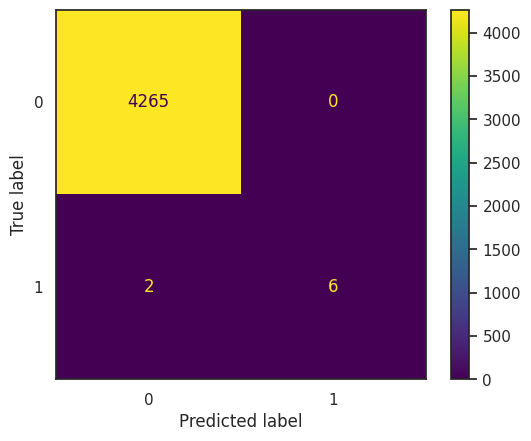

In [ ]:
print(classification_report(y_test, y_pred, target_names=y_labels))



```
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      4265
       Fraud       1.00      0.75      0.86         8

    accuracy                           1.00      4273
   macro avg       1.00      0.88      0.93      4273
weighted avg       1.00      1.00      1.00      4273
```



In [ ]:
lda_metrics = calculate_metrics(y_test, y_pred, lda_duration, 'LDA')
print(lda_metrics)



```
accuracy                                                 0.999532
precision                                                     1.0
recall                                                       0.75
roc_auc                                                     0.875
f1_score                                                 0.857143
cohen_kappa                                              0.856913
precision_both                           [0.999531286618233, 1.0]
recall_both                                           [1.0, 0.75]
fbeta_both               [0.9997655883731833, 0.8571428571428571]
support_both                                            [4265, 8]
time_to_fit (seconds)                                    1.873828
```



## 6.4 Support Vector Machine

---

▸ SVM 커널과 '데이터와의 적합성'

    SVM은 데이터를 고차원 공간으로 매핑한 다음 해당 공간에서 선형 분리를 수행한다.
    이때 사용하는 함수가 바로 커널(kernel function)이다.

    - RBF → 둥근/곡선적 결정 경계
    - Polynomial → 다항식 형태의 곡선
    - Sigmoid → 신경망의 활성함수처럼 선형+비선형이 섞인 형태

    결국 커널이 데이터를 어떤 공간으로 옮기느냐가 결정 경계의 모양을 결정한다.
    따라서 데이터 구조가 커널이 만들 수 있는 결정 경계의 형태와 맞아야 성능이 좋다는 의미이다.

▸ Sigmoid의 문제점

    이상 거래는 도형처럼 깔끔한 모양이 아니고, 군데군데 섞여 있는 형태를 띤다.
    그리고 Feature의 조합이 복잡할 수 있다. (금액 + 시간대 + 거래 유형 + 지역 + 카드 상태 등)

    Sigmoid 커널은 압축성이 강하기 때문에 복잡한 패턴을 펼치기 어렵고, 저차원적인 결정 경계만을 만들 수 있기에 이 데이터에는 부적합하다.

In [ ]:
param_grid = {'C': np.logspace(-1, 3, 5),
              'gamma': np.logspace(-4, 0, 5),
              'class_weight': ['balanced']}

svc_clf = SVC(random_state=0)

gs_svc = GridSearchCV(svc_clf, param_grid=param_grid)

start = time()
gs_svc.fit(X_train_std, y_train)
svc_duration = time() - start

print('GridSearchCV of SVC took {:.2f} seconds for {} candidate parameter settings.'.format(svc_duration,
                                                                                            len(gs_svc.cv_results_['params'])))

print('Optimal C: {} Optimal gamma: {}'.format(gs_svc.best_params_['C'], gs_svc.best_params_['gamma']))
print('Accuracy (train): {:.2f}'.format(gs_svc.score(X_train_std, y_train)))
print('Accuracy (test): {:.2f}'.format(gs_svc.score(X_test_std, y_test)))



```
GridSearchCV of SVC took 209.18 seconds for 25 candidate parameter settings.
Optimal C: 1000.0 Optimal gamma: 0.001
Accuracy (train): 1.00
Accuracy (test): 1.00
```



In [ ]:
svc_cv = get_cross_val(gs_svc, X_test_std, y_test, 'Support Vector Machine')
print(svc_cv.round(2))



```
mean                  0.53
standard deviation    0.32
p025                  0.05
p975                  0.97
```



In [ ]:
y_pred = gs_svc.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_svc.classes_)
disp.plot()
plt.show()

    SVM이 Kernel Function이 데이터와 적합하지 않을 수 있음
    Sigmoid를 사용했는데, 데이터를 저차원으로 mapping하면서 일어나는 데이터의 손실이 클 것이라 예상

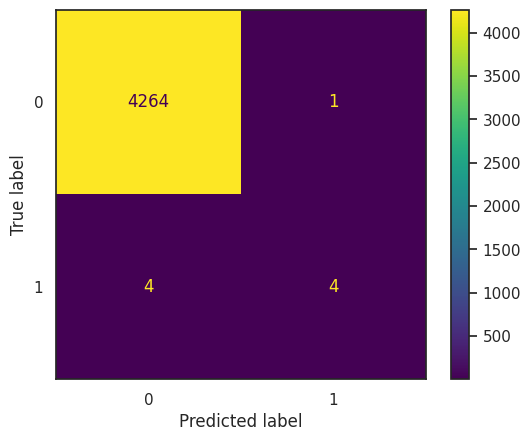

In [ ]:
print(classification_report(y_test, y_pred, target_names=y_labels))



```
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      4265
       Fraud       0.80      0.50      0.62         8

    accuracy                           1.00      4273
   macro avg       0.90      0.75      0.81      4273
weighted avg       1.00      1.00      1.00      4273
```



In [ ]:
svc_metrics = calculate_metrics(y_test, y_pred, svc_duration, 'Support Vector Machine')
print(svc_metrics)



```
accuracy                                                  0.99883
precision                                                     0.8
recall                                                        0.5
roc_auc                                                  0.749883
f1_score                                                 0.615385
cohen_kappa                                               0.61483
precision_both                          [0.9990627928772259, 0.8]
recall_both                             [0.9997655334114889, 0.5]
fbeta_both               [0.9994140396109223, 0.6153846153846154]
support_both                                            [4265, 8]
time_to_fit (seconds)                                  209.175052
```



## 6.5 Random Forest

In [ ]:
param_grid = {'n_estimators': np.arange(100, 800, 200, dtype=int),
              'max_features': [None, 'sqrt', 'log2'],
              'max_depth': [None, 3, 5]}

rf_clf = RandomForestClassifier(oob_score=True, random_state=0)

gs_rf = GridSearchCV(rf_clf, param_grid=param_grid)

start = time()
gs_rf.fit(X_train_std, y_train)
rf_duration = time() - start

print('GridSearchCV of RF took {:.2f} seconds for {} candidate parameter settings.'.format(rf_duration,
                                                                                           len(gs_rf.cv_results_['params'])))

print('Optimal n_estimators: {} Optimal max_features: {} Optimal max_depth'.format(gs_rf.best_params_['n_estimators'],
                                                                                   gs_rf.best_params_['max_features'],
                                                                                   gs_rf.best_params_['max_depth']))
print('Accuracy (train): {:.2f}'.format(gs_rf.score(X_train_std, y_train)))
print('Accuracy (test): {:.2f}'.format(gs_rf.score(X_test_std, y_test)))



```
정말 미친 듯이 오래 걸렸다.. 약 1시간 정도
```





```
GridSearchCV of RF took 3795.51 seconds for 36 candidate parameter settings.
Optimal n_estimators: 100 Optimal max_features: sqrt Optimal max_depth
Accuracy (train): 1.00
Accuracy (test): 1.00
```



In [ ]:
clf_rf = RandomForestClassifier(n_estimators=gs_rf.best_params_['n_estimators'],
                                max_features=gs_rf.best_params_['max_features'],
                                max_depth=gs_rf.best_params_['max_depth'],
                                oob_score=True,
                                random_state=0)

rf_cv = get_cross_val(clf_rf, X_test_std, y_test, 'Random Forest')
print(rf_cv.round(2))



```
mean                  0.47
standard deviation    0.40
p025                  0.00
p975                  0.97
```



In [ ]:
y_pred = gs_rf.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_rf.classes_)
disp.plot()
plt.show()

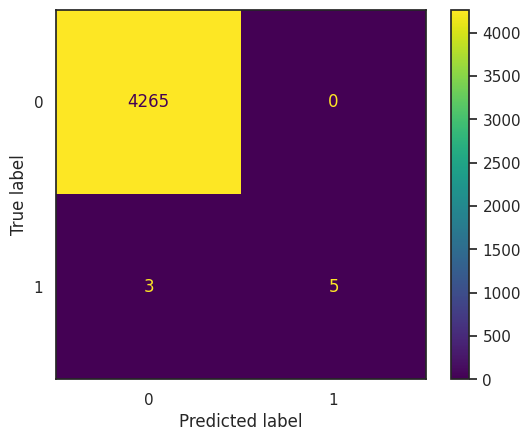

In [ ]:
print(classification_report(y_test, y_pred, target_names=y_labels))



```
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      4265
       Fraud       1.00      0.62      0.77         8

    accuracy                           1.00      4273
   macro avg       1.00      0.81      0.88      4273
weighted avg       1.00      1.00      1.00      4273

```



In [ ]:
rf_metrics = calculate_metrics(y_test, y_pred, rf_duration, 'Random Forest')
print(rf_metrics)



```
accuracy                                                 0.999298
precision                                                     1.0
recall                                                      0.625
roc_auc                                                    0.8125
f1_score                                                 0.769231
cohen_kappa                                              0.768898
precision_both                          [0.9992970946579194, 1.0]
recall_both                                          [1.0, 0.625]
fbeta_both               [0.9996484237665534, 0.7692307692307693]
support_both                                            [4265, 8]
time_to_fit (seconds)                                 3795.510297
```



▸ permutation_importance

```
예를 들어 feature X1에 대해
1. 원본 데이터로 모델 성능 측정 → baseline score
2. X1 컬럼을 무작위로 섞음 → 정보 붕괴
3. 이 새 데이터로 모델 성능 측정
4. 1과 3의 차이 → importance
5. n_repeats만큼 반복 후 평균·표준편차 계산

위 과정을 모든 feature에 대해 수행
```



In [ ]:
result = permutation_importance(gs_rf, X_test_std, y_test, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

X_test_df = pd.DataFrame(X_test_std, columns=list(data.columns)[1:])

f, ax = plt.subplots(figsize=(8, 16))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_df.columns[sorted_idx])
ax.set_title('Permutation importances (test set)')
plt.tight_layout()
plt.show()

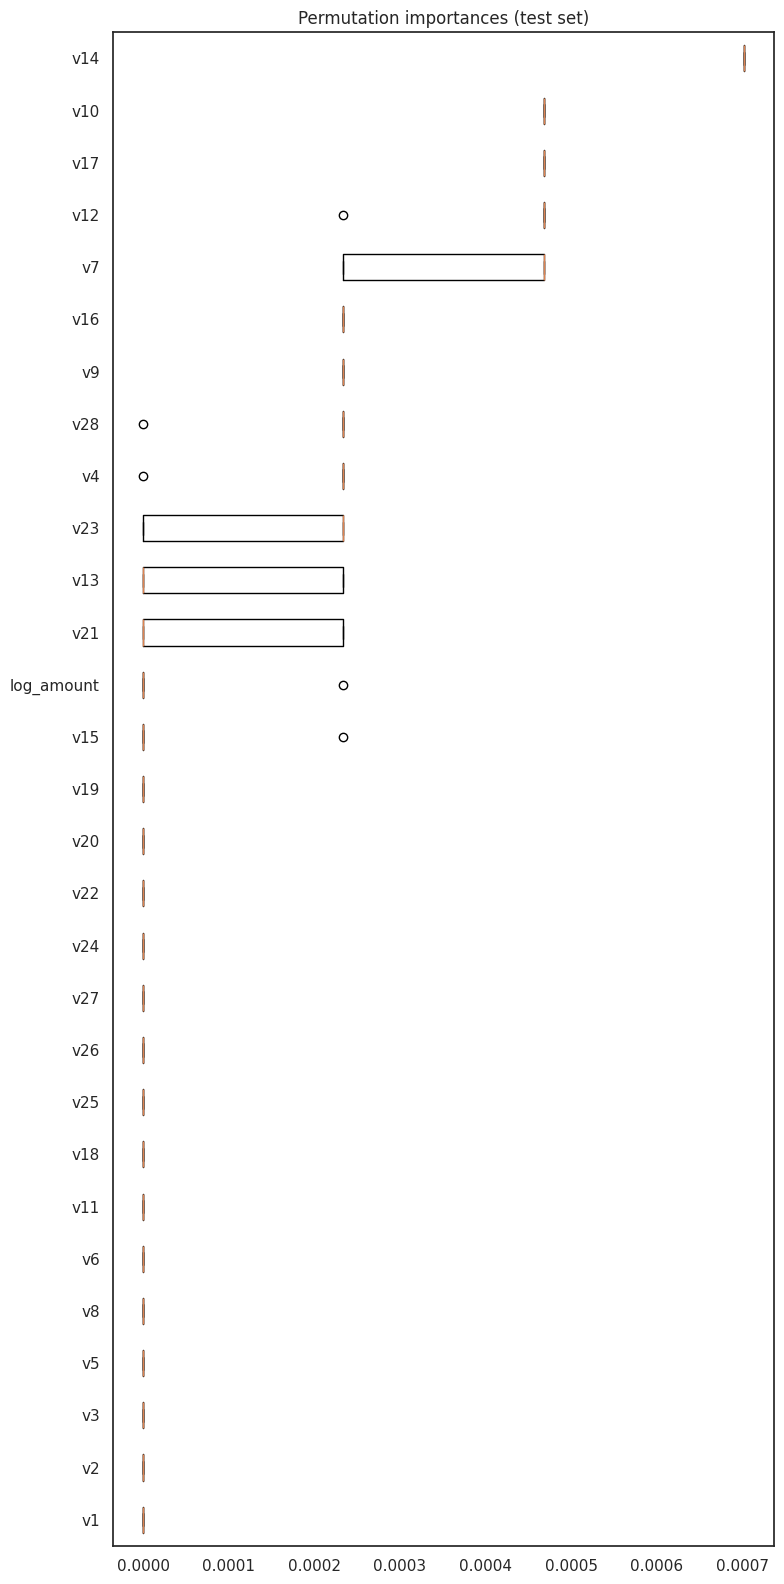

## 6.6 모델 비교

In [ ]:
model_metrics = pd.concat([lr_metrics, knn_metrics, lda_metrics, svc_metrics, rf_metrics], axis=1).T

model_metrics.apply(lambda e: [np.round(val, 4) for val in e]).sort_values(by='f1_score', ascending=False)

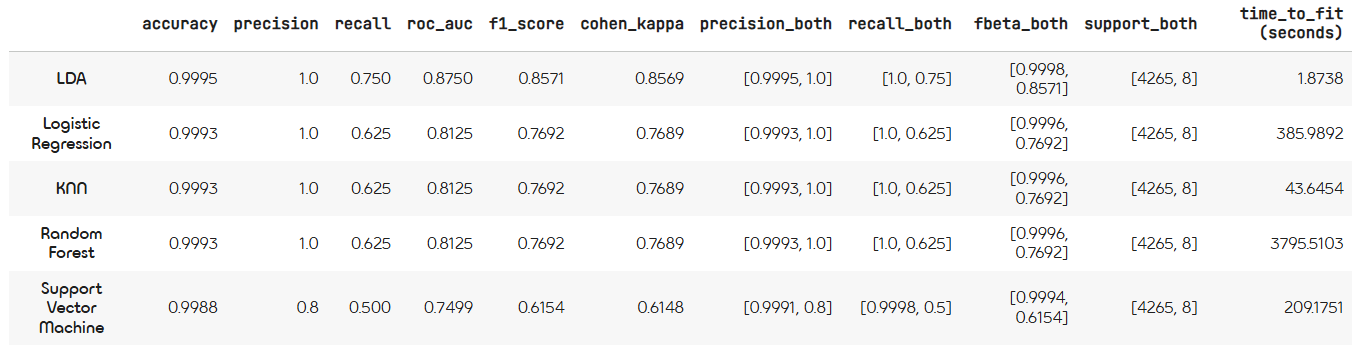

In [ ]:
cross_vals = pd.concat([lr_cv, knn_cv, lda_cv, svc_cv, rf_cv], axis=1).T

cross_vals = cross_vals.round(4).sort_values(by='mean', ascending=False)
print(cross_vals)



```
                                mean  standard deviation    p025    p975
Linear Discriminant Analysis  0.7600              0.1306  0.6667  0.9800
KNN                           0.7333              0.3887  0.0667  1.0000
Support Vector Machine        0.5333              0.3232  0.0500  0.9667
Logistic Regression           0.5267              0.2800  0.0500  0.7867
Random Forest                 0.4667              0.4000  0.0000  0.9667
```



In [ ]:
fig = plt.figure(figsize=(8, 6))

for i in range(len(cross_vals.index)):
    plt.errorbar(x=i, y=cross_vals.iloc[i, 0],
                 xerr=0.25,
                 yerr=cross_vals.iloc[i, 1],
                 linestyle='',
                 label=list(cross_vals.index)[i])

plt.title('Mean F1 Score (+/- 1 std) by Model,\nbased on 5-fold cross-validation on the test set.')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend(loc='lower left')
plt.show()

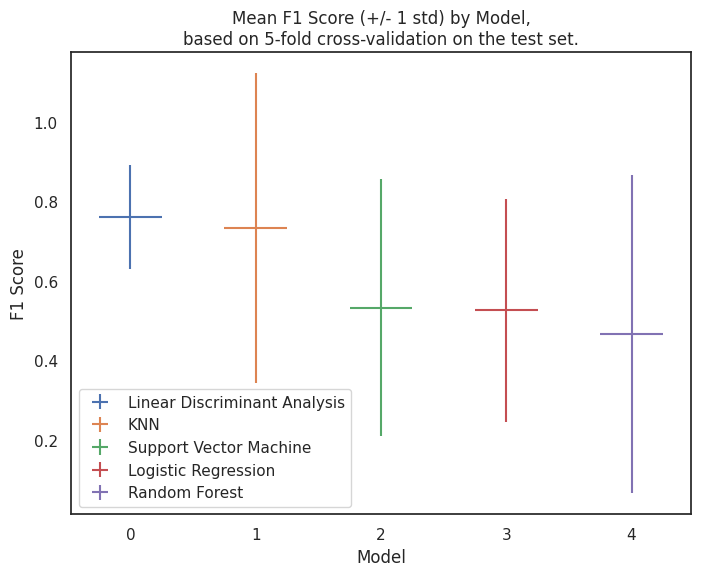

# 7. Feature Engineering

## 7.1 Over-sampling (numpy)

---

    결정 경계를 정하는 데에 있어서 Over sampling은 크게 도움이 되지 않는 느낌...!

In [ ]:
bool_y_train = y_train != 0

pos_features = X_train_std[bool_y_train]
neg_features = X_train_std[~bool_y_train]

pos_labels = y_train[bool_y_train]
neg_labels = y_train[~bool_y_train]

pos_features.shape, neg_features.shape



```
((17, 29), (9951, 29))
```



In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape, res_pos_labels.shape



```
((9951, 29), (9951,))
```



In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)

resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape, resampled_labels.shape



```
((19902, 29), (19902,))
```



In [ ]:
param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'],
              'n_components': np.arange(1, 5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda_resamp = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda_resamp.fit(resampled_features, resampled_labels)
lda_duration = time() - start

print('GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.'.format(lda_duration,
                                                                                            len(gs_lda_resamp.cv_results_['params'])))
print('Optimal solver: {} Optimal shrinkage: {} Optimal n_components: {}'.format(gs_lda_resamp.best_params_['solver'],
                                                                                 gs_lda_resamp.best_params_['shrinkage'],
                                                                                 gs_lda_resamp.best_params_['n_components']))
print('Accuracy (train): {:.4f}'.format(gs_lda_resamp.score(resampled_features, resampled_labels)))
print('Accuracy (test): {:.4f}'.format(gs_lda_resamp.score(X_test_std, y_test)))



```
GridSearchCV of LDA took 2.50 seconds for 16 candidate parameter settings.
Optimal solver: lsqr Optimal shrinkage: None Optimal n_components: 1
Accuracy (train): 0.9894
Accuracy (test): 0.9794
```



In [ ]:
y_pred = gs_lda_resamp.predict(X_test_std)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_lda_resamp.classes_)
disp.plot()
plt.show()



```
당연하게도 이상 거래가 아닌 건수를 더 추가했기에, 기존보다 오탐이 더 늘어났다.
```



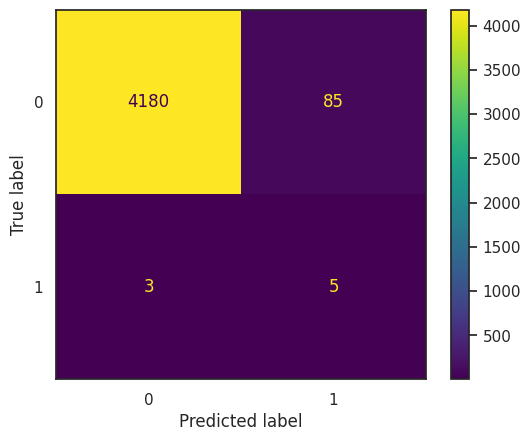

In [ ]:
print(calculate_metrics(y_test, y_pred, lda_duration, 'Oversampling Numpy'))



```
accuracy                                                  0.979406
precision                                                 0.055556
recall                                                       0.625
roc_auc                                                   0.802535
f1_score                                                  0.102041
cohen_kappa                                               0.098942
precision_both           [0.9992828113793928, 0.05555555555555555]
recall_both                            [0.9800703399765534, 0.625]
fbeta_both               [0.9895833333333334, 0.10204081632653061]
support_both                                             [4265, 8]
time_to_fit (seconds)                                      2.50001
```



    단순 샘플링으로는 좋은 결과를 얻기 힘들다 !!

## 7.2 Over-sampling (imbalance-learn)

---

    imblearn의 RandomOverSampler를 이용하면 동일한 결과를 얻을 수 있다.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train_std, y_train)

from collections import Counter

print(sorted(Counter(y_resampled).items()))



```
[(0, 9951), (1, 9951)]
```



# 8. 결론

---

▸ Imbalanced Problem과 Under-sampling, Over-sampling

    1. 현업의 데이터는 대부분의 경우(거의 모든 경우) 분석하고자 하는 클래스의 비율이 Imbalance하기 때문에, 어떻게 Imbalance를 해결할지에 대한 고민이 필요하다.
    2. 가장 먼저 시도할 수 있는 방법은 Under-sampling 방법이다.
    - Over-sampling은 많이 시도되지만, 결국 분포를 추정해야하고, Interpolation과 같이 분포의 가운데 어딘가를 추정해야하기 때문에 불확실성이 Under-sampling 방법보다 높다.

    3. Under-sampling 방법을 통해 데이터의 모수를 작게 만들고 학습을 통해 클래스의 경계를 학습해보고 결과를 살펴본다.
    4. 그럼에도 불구하고 결과가 맞지 않거나, 결과에 대한 설명이 어렵다면 Over-sampling으로 데이터를 1:1 비율로 만들어 특성을 살펴보는 것도...
    - (그러나 이 방법이 경계는 뚜렷하게 만들어주지만, 샘플의 개수에 의한 가중치가 실제 분포와 달라지기 때문에 추천하지는 않는다.)

▸ 이상 거래 데이터

    이상 거래와 같이 매우 민감한 모델의 경우에는 Recall이 매우 높아야 한다.
    Precision도 물론 중요하지만, 굳이 가중치를 더 보자면 Recall은 항상 1.0이 나와야 한다는 뜻이다.

▸ Over-sampling

    Over-sampling을 통해 오히려 오탐이 더 늘어나는 것을 확인했다.
    앞서 작성했던 1:1 비율로 맞추는 것을 추천하지 않는 이유에서 나오는 결과이다.